# Proximal gradient algorithm
This first tutorial details how to use a proximal gradient algorithm
to solve the LASSO problem:
$$
\min_u \;f(u) =  \frac{1}{2}\| A u - b \|_2^2 + \lambda \|u \|_1
$$
with $A$ given matrix, and $b$ vector of observation.
As the function $f$ is non-smooth and additive, the resolution of the LASSO
problem is a good use case for the proximal gradient algorithm.

## Settings
We import the usual packages:

In [2]:
using Printf, Random
using LinearAlgebra
using JuMP

Fix seed

In [27]:
Random.seed!(2713);

We first generate artificial data to study the algorithm:

In [28]:
include("data.jl")

nVariables = 50;
nCassures = 50;
xMin, xMax = build_bounds(nVariables)
A = build_X(nVariables, nCassures, xMin, xMax);
b = randn(nCassures)
λ = 50.0;

Build oracle for objective:

In [29]:
f(u) = 0.5 * norm(A*u - b, 2)^2 + λ * norm(u, 1);

and we add a function to evaluate the prox operator of the $\ell_1$-norm:

In [30]:
function prox_g(v, u, ε, λ)
    step = ε * λ
    for i in 1:length(u)
        if u[i] >= 0
            v[i] = max(u[i]-step,0)
        else
            v[i] = min(u[i]+step,0)
        end
    end
    return v
end;

Get optimal solution with a QP solver

In [31]:
using OSQP
# using CPLEX

function get_solution(A, b, λ)
    n, m = size(A)
    model = Model(with_optimizer(OSQP.Optimizer))
    JuMP.set_silent(model)
    # Variable u
    @variable(model, u[1:m])
    # Variable t, linearizing the \|.\|_1 term
    @variable(model, t[1:m])
    @constraint(model, t .>= u)
    @constraint(model, t .>= -u)
    @objective(model, Min, 0.5 * dot(A*u - b, A*u - b) + λ * sum(t))
    JuMP.optimize!(model)
    return JuMP.objective_value(model)
end
optsol = get_solution(A, b, λ)
println("Optimal solution is equal to ", optsol)

Optimal solution is equal to 12.090246585596102


## Proximal gradient algorithm
At iteration $k$ and iterate $u_k$, the proximal gradient algorithm computes
$$
\begin{aligned}
& v_k = u_k - \varepsilon_k \nabla F(u_k) \\
& u_{k+1} = \text{prox}_{\varepsilon_k g}(v_k)
\end{aligned}
$$

In [38]:
function proximal_gradient(A, b, u0, ε; maxit=1000)
    # iterate
    u = copy(u0)
    # intermediate vector
    v = similar(u0)
    # instantiate array to store trace
    trace_f = Float64[]
    push!(trace_f, f(u))

    for nit in 1:maxit
        u = prox_g(v, u - ε*(transpose(A)*A*u-transpose(A)*b), ε, λ)
        # TODO: code proximal gradient algorithm here
        # evaluate objective at current point
        f_k = f(u)
        #TODO
        push!(trace_f, f_k)
    end
    return trace_f
end

proximal_gradient (generic function with 1 method)

We know that the optimal step is given by the inverse of the Lipschitz
coefficient $L$ of the gradient of $F$, the smooth part of the objective.
As $F(u) = 0.5 \|A u - b \|_2^2$, we get

In [39]:
L = eigmax(A' * A)
step = 1 / L

3.663415689163745e-6

We choose as initial point the vector $u_0 = 0$.

In [40]:
u0 = zeros(nVariables) ;

## Accelerated proximal gradient
The accelerated proximal gradient algorithm is a variant of the proximal
gradient algorithm, which is known for its better performance.

At iteration $k$ and iterate $u_k$, the accelerated proximal gradient
algorithm computes
$$
\begin{aligned}
& w_k = u_k - \varepsilon_k \nabla F(u_k) \\
& v_{k+1} = \text{prox}_{\varepsilon_k g}(w_k) \\
& u_{k+1} = v_{k+1} + \dfrac{k - 1}{k+2} (v_{k+1} - v_k)
\end{aligned}
$$

In [41]:
function accelerated_proximal_gradient(A, b, u0, ε; maxit=1000)
    # intermediate vector
    u = copy(u0)
    v_next = copy(u0)
    v_prev = copy(u0)
    w = similar(u0)
    trace_f = Float64[]
    push!(trace_f, f(u))

    for nit in 1:maxit
        v_next = prox_g(v_next, u - ε*(transpose(A)*A*u-transpose(A)*b), ε, λ)
        u = v_next + (v_next-v_prev)*(nit-1)/(nit+2)
        f_k = f(u)
        # TODO: code accelerated proximal gradient here
        push!(trace_f, f_k)
        copy!(v_prev, v_next)
    end
    return trace_f
end

accelerated_proximal_gradient (generic function with 1 method)

## Final results on simulated data

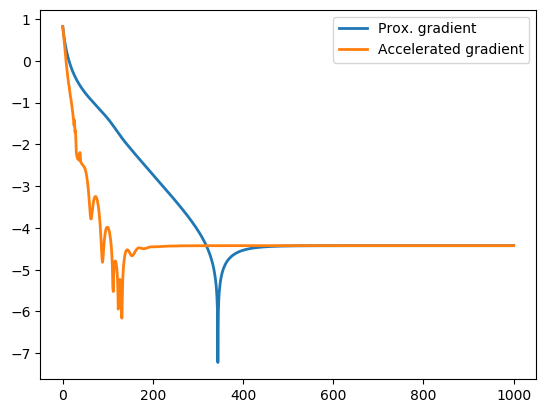

PyObject <matplotlib.legend.Legend object at 0x16cc49210>

In [46]:
using PyPlot
trace_1 = proximal_gradient(A, b, u0, step, maxit=1000)
trace_2 = accelerated_proximal_gradient(A, b, u0, step, maxit=1000)

plot(log10.(abs.(trace_1 .- optsol)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_2 .- optsol)), lw=2., label="Accelerated gradient")
legend()

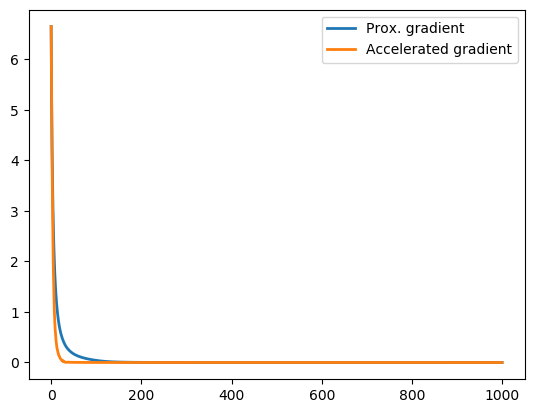

PyObject <matplotlib.legend.Legend object at 0x16cdcf610>

In [47]:
plot(trace_1 .- optsol, lw=2., label="Prox. gradient")
plot(trace_2 .- optsol, lw=2., label="Accelerated gradient")
legend()

## Final results on real data

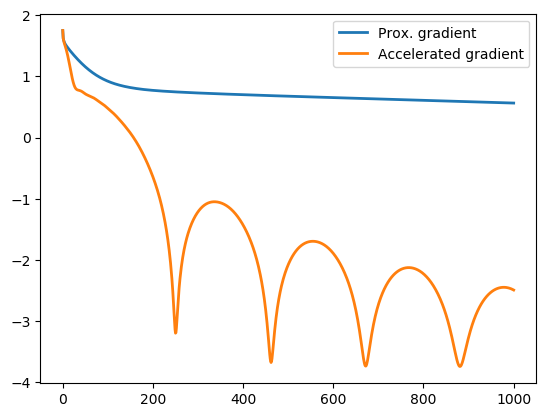

PyObject <matplotlib.legend.Legend object at 0x16cf364d0>

In [48]:
include("libsvm_parser.jl")
data = parse_libsvm("diabetes")

A = to_dense(data);
b = data.labels;
λ = 50.0;
u0 = zeros(size(A,2));

L = eigmax(A' * A)
step = 1 / L

optsol = get_solution(A, b, λ)

trace_1 = proximal_gradient(A, b, u0, step)
trace_2 = accelerated_proximal_gradient(A, b, u0, step)

plot(log10.(abs.(trace_1 .- optsol)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_2 .- optsol)), lw=2., label="Accelerated gradient")
legend()

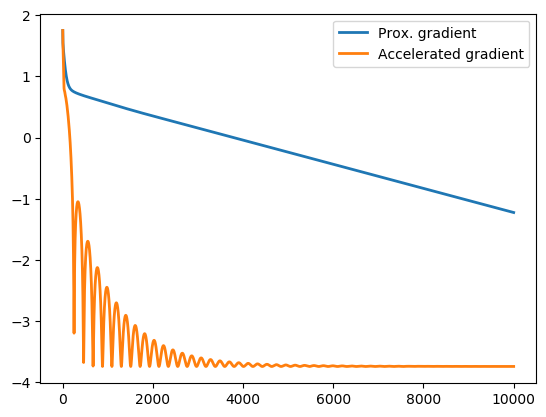

PyObject <matplotlib.legend.Legend object at 0x16d0c76d0>

In [49]:
trace_1 = proximal_gradient(A, b, u0, step, maxit=10000)
trace_2 = accelerated_proximal_gradient(A, b, u0, step, maxit=10000)

plot(log10.(abs.(trace_1 .- optsol)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_2 .- optsol)), lw=2., label="Accelerated gradient")
legend()